## [step1] convert h5 data to npy

In [2]:
import numpy as np
from tqdm import tqdm

import random
import h5py
import os
import csv

In [3]:
class H5DataLoader:
    def __init__(self, data_path, mode='train', img_size=256):
        self.it = 0
        self.mode = mode
        self.label = None
        if mode == 'train':
            self.off = 0
            self.label = {r['ID']: r['label'] for r in csv.DictReader(open(os.path.join(data_path, 'train.csv')))}
            self.data = h5py.File(os.path.join(data_path, "train.h5"), 'r')
        elif mode == 'test':
            self.off = 50000
            self.data = h5py.File(os.path.join(data_path, "test.h5"), 'r')
        self.img_size = img_size

    def __iter__(self):
        return self

    def __next__(self):
        index = self.it
        if index >= len(self.data):
            raise StopIteration
        data = self.data[str(index + self.off)]
        label = index + self.off
        if self.mode == 'train':
            label = self.label[str(index)]
            label = np.array(label).astype(int)
        self.it += 1
        return str(index + self.off), data, label

    def __len__(self):
        return len(self.data)

In [4]:
def h5_to_np(data_path, save_path):
    [os.makedirs("%s/train/%d" % (save_path, i), exist_ok=True) for i in range(10)]
    os.makedirs("%s/test" % save_path, exist_ok=True)

    train_dl = H5DataLoader(data_path, mode='train')
    bar = tqdm(train_dl, total=len(train_dl))
    for index, dd, gt in bar:
        np.save("%s/train/%d/%05d" % (save_path, gt, int(index)), dd)
    print('train data save complete')
    test_dl = H5DataLoader(data_path, mode='test')
    bar = tqdm(test_dl, total=len(test_dl))
    for index, dd, gt in bar:
        np.save("%s/test/%05d" % (save_path, int(index)), dd)

h5 파일은 pickel error 로 dataloader 에서 multiprocess 를 사용할수 없기에 npy 로 바꿔 사용

In [ ]:
# run
h5_to_np('/coldjeans/Data/raw', "/coldjeans/Data/np")

 68%|██████▊   | 33966/50000 [08:50<04:12, 63.61it/s]

## [step2] training rotation model
데이터 rotation x, y, z 값 estimation

##### 2.1 define model
build regression model 
input : B x n x 3
output : B x 3

In [9]:
import torch
from torch import Tensor
import torch.nn as nn


class DeepHoughModel(nn.Module):
    def __init__(self, input_size=10000):
        super(DeepHoughModel, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Conv1d(3, 16, (100, ), (5, ))
        self.l2 = nn.Conv1d(16, 64, (100, ), (5, ))
        self.l3 = nn.Conv1d(64, 128, (10, ), (5, ))
        self.l4 = nn.Conv1d(128, 256, (10, ), (5, ))
        self.l5 = nn.Conv1d(256, 512, (10, ), (5, ))
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 3)
        self.active = nn.ReLU()
        self.fc_active = nn.Tanh()

    def forward(self, x: Tensor) -> Tensor:
        c = x.permute(0, 2, 1)
        c = self.l1(c)
        c = self.active(c)
        c = self.l2(c)
        c = self.active(c)
        c = self.l3(c)
        c = self.active(c)
        c = self.l4(c)
        c = self.active(c)
        c = self.l5(c)
        c = self.active(c)
        feature = torch.mean(c, dim=2)
        c = self.fc1(feature)
        c = self.fc_active(c)
        pred = self.fc2(c)

        return pred

##### 2.2 define viz function

In [10]:
def derotation(a, b, c, dots):
    def _rotation(a, b, c, dots):
        mx = np.array([[1, 0, 0], [0, np.cos(a), -np.sin(a)], [0, np.sin(a), np.cos(a)]])
        my = np.array([[np.cos(b), 0, np.sin(b)], [0, 1, 0], [-np.sin(b), 0, np.cos(b)]])
        mz = np.array([[np.cos(c), -np.sin(c), 0], [np.sin(c), np.cos(c), 0], [0, 0, 1]])
        m = np.dot(np.dot(mx, my), mz)
        dots = np.dot(dots, m.T)
        return dots
    dot = _rotation(0, 0, c, dots)
    dot = _rotation(0, b, 0, dot)
    dot = _rotation(a, 0, 0, dot)
    return dot


def viz_result(data, pred, gt):
    b_size = data.shape[0]
    in_list = []
    pred_list = []
    gt_list = []
    for i in range(b_size):
        dd = data[i].cpu().detach().numpy()
        in_list.append(data2img(dd.copy()))
        pp = pred[i].cpu().detach().numpy()
        gg = gt[i]
        x, y, z = pp
        # x *= np.pi*2
        # y *= np.pi*2
        # z *= np.pi*2
        result_data = derotation(-x, -y, -z, dd.copy())
        result_img = data2img(result_data)
        pred_list.append(result_img)
        x, y, z = gg
        # x *= np.pi*2
        # y *= np.pi*2
        # z *= np.pi*2
        gt_data = derotation(-x, -y, -z, dd.copy())
        gt_img = data2img(gt_data)
        gt_list.append(gt_img)

    in_list = np.concatenate(in_list, axis=1)
    pred_list = np.concatenate(pred_list, axis=1)
    gt_list = np.concatenate(gt_list, axis=1)
    return np.concatenate([in_list, pred_list, gt_list])


def data2img(data, img_size=224):
    w = 1
    index = np.array(data)
    index = np.array((index + 1) * (img_size // 2), dtype=int)
    img = np.zeros((img_size, img_size, img_size), dtype=float)
    for i in index:
        x, y, z = i
        # img[x, y, z] += 1
        img[x - w:x + w, y - w:y + w, z - w:z + w] += 1
    # print(np.max(img))
    img = img[img_size // 2, :, :]
    # img = cv2.blur(img, (5, 5))
    # img = cv2.blur(img, (11, 11))
    img[img > 1] = 1
    img *= 255
    return img.astype(np.uint8)

##### 2.3 define data loader

In [11]:
from torch.utils.data import Dataset
from torchvision import transforms

class RotationLoader(Dataset):
    def __init__(self, data_path, mode='train', img_size=128):
        # data_path="F:\\Data\\mnist_3d", mode='train'
        self.mode = mode
        self.data, self.label = self.get_img_list(data_path)
        self.img_size = img_size
        self.off = None
        self.transform_3d = transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize(mean=[0.5]*img_size,
                                                                  std=[0.225]*img_size)
                                             ])
        self.transform = transforms.Compose([transforms.ToTensor()])

    def get_img_list(self, data_path):
        if self.mode == 'test':
            img_list = glob(os.path.join(data_path, 'test', '*.npy'))
            label_list = [int(img_l.split(os.sep)[-1].split('.')[0]) for img_l in img_list]
            return img_list, label_list
        else:
            img_list = []
            label_list = []
            for i in range(10):
                sub_path = os.path.join(data_path, 'train', '%d' % i)
                sub_img_list = [os.path.join(sub_path, s) for s in os.listdir(sub_path) if 'npy' in s]
                sub_img_num = len(sub_img_list)
                sub_img_list.sort()
                if self.mode == 'train':
                    sub_img_list = sub_img_list[:int(sub_img_num*0.9)]
                elif self.mode == 'val':
                    sub_img_list = sub_img_list[int(sub_img_num*0.9):]
                else:
                    raise AssertionError
                sub_label = [i for _ in range(len(sub_img_list))]
                img_list += sub_img_list
                label_list += sub_label

            return img_list, label_list

    @staticmethod
    def rotation(a, b, c, dots):
        def _rotation(a, b, c, dots):
            mx = np.array([[1, 0, 0], [0, np.cos(a), -np.sin(a)], [0, np.sin(a), np.cos(a)]])
            my = np.array([[np.cos(b), 0, np.sin(b)], [0, 1, 0], [-np.sin(b), 0, np.cos(b)]])
            mz = np.array([[np.cos(c), -np.sin(c), 0], [np.sin(c), np.cos(c), 0], [0, 0, 1]])
            m = np.dot(np.dot(mx, my), mz)
            dots = np.dot(dots, m.T)
            return dots
        dot = _rotation(a, 0, 0, dots)
        dot = _rotation(0, b, 0, dot)
        dot = _rotation(0, 0, c, dot)
        return dot

    @staticmethod
    def derotation(a, b, c, dots):
        def _derotation(a, b, c, dots):
            mx = np.array([[1, 0, 0], [0, np.cos(a), -np.sin(a)], [0, np.sin(a), np.cos(a)]])
            my = np.array([[np.cos(b), 0, np.sin(b)], [0, 1, 0], [-np.sin(b), 0, np.cos(b)]])
            mz = np.array([[np.cos(c), -np.sin(c), 0], [np.sin(c), np.cos(c), 0], [0, 0, 1]])
            m = np.dot(np.dot(mx, my), mz)
            dots = np.dot(dots, m.T)
            return dots

        dot = _derotation(0, 0, c, dots)
        dot = _derotation(0, b, 0, dot)
        dot = _derotation(a, 0, 0, dot)
        return dot


    def random_rotation(self, data):
        # 45 -np.pi/4
        # off = np.pi*2
        if self.off is None:
            off = 0.5*np.pi
        else:
            off = self.off
        x, y, z = 2*np.random.rand(3) - 1
        x *= off
        y *= off
        z *= off
        return self.rotation(x, y, z, data), [x, y, z]

    def cvt_data(self, data):
        data_np = np.array(data[:, 14, :], dtype=np.float32)
        data_np -= np.min(data_np)
        data_np /= np.max(data_np)
        img = np.array(data_np*255, dtype=np.uint8)
        return cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    def data2img(self, data):
        w = 1
        index = np.array(data)
        index = np.array((index + 1) * (self.img_size//2), dtype=int)
        img = np.zeros((self.img_size, self.img_size, self.img_size), dtype=float)
        for i in index:
            x, y, z = i
            img[x-w:x+w, y-w:y+w, z-w:z+w] += 1
        # print(np.max(img))
        img /= np.max(img)
        img *= 255
        return img.astype(np.uint8)

    def sampling(self, data):
        data_len = data.shape[0]
        try:
            idx = np.random.choice(np.array(range(0, data_len)), 10000, False)
        except:
            idx = np.random.choice(np.array(range(0, data_len)), 10000)
        idx.sort()
        feature = data[idx]
        # sample_idx = torch.tensor(sample(range(0, data.shape[0]), 10000))
        # feature = torch.index_select(data, 1, sample_idx)
        return feature

    def __getitem__(self, index):
        # index = 0
        data = self.data[index]
        label = self.label[index]
        try:
            data = np.load(data)
        except Exception as e:
            print('='*100)
            print(index, e)
            print('='*100)
            index = 0
            data = self.data[index]
            data = np.load(data)
            label = self.label[index]

        data, rota = self.random_rotation(data)
        data = self.sampling(data.astype(np.float32))

        # data = self.transform(data)[0]
        # print(data.shape)
        return data, label, np.array(rota, dtype=float)

    def __len__(self):
        return len(self.data)


class TestRotationLoader(RotationLoader):
    def __init__(self, data_path, mode='train', img_size=128):
        # data_path="F:\\Data\\mnist_3d", mode='train'
        super().__init__(data_path, mode, img_size)
        self.mode = mode
        self.data, self.label = self.get_img_list(data_path)
        self.img_size = img_size
        self.transform_3d = transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize(mean=[0.5]*img_size,
                                                                  std=[0.225]*img_size)
                                             ])
        self.transform = transforms.Compose([transforms.ToTensor()])

    def random_rotation(self, data, off=None):
        # 45 -np.pi/4
        # off = np.pi*2
        if off is None:
            off = np.pi * 0.5
        x, y, z = np.random.rand(3)
        # x, y, z = 1.0, 1.0, 1.0
        x *= off
        y *= off
        z *= off
        return self.rotation(x, y, z, data), [x, y, z]

    def __getitem__(self, index):
        # index = 0
        data = self.data[index]
        label = self.label[index]
        try:
            data = np.load(data)
        except Exception as e:
            print('='*100)
            print(index, e)
            print('='*100)
            index = 0
            data = self.data[index]
            data = np.load(data)
            label = self.label[index]

        data, rota = self.random_rotation(data, np.pi*0.2)
        data = self.sampling(data.astype(np.float32))

        return data, label

    def __len__(self):
        return len(self.data)


class TrainDataLoader(RotationLoader):
    def __init__(self, data_path):
        super().__init__(data_path)
        self.data, self.label = self.get_img_list(data_path)
        self.idx = 0

    def get_img_list(self, data_path):
        img_list = []
        label_list = []
        for i in range(10):
            sub_path = os.path.join(data_path, 'train', '%d' % i)
            sub_img_list = [os.path.join(sub_path, s) for s in os.listdir(sub_path) if 'npy' in s]
            sub_img_list.sort()
            sub_label = [i for _ in range(len(sub_img_list))]
            img_list += sub_img_list
            label_list += sub_label

        return img_list, label_list

    def __getitem__(self, index):
        data_name = self.data[index]
        label = self.label[index]
        data = np.load(data_name)
        data = self.sampling(data.astype(np.float32))
        name = os.path.split(data_name)[-1].split('.')[0]
        return data, label, name

##### 2.4 train rotation
원본 데이터 train data 에서 random 3d rotation (a,b,c) 를 시킨 데이터를 생성  
regression model 에 입력으로 rotated 데이터가 들어가 (a', b', c') 값을 estimation  
gt (a, b, c) 와 prediction result (a', b', c') 사이의 l1, l2 distance 값을 loss로 학습 

In [ ]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

In [13]:
def train_rotation(data_path, save_path):
    os.makedirs(save_path, exist_ok=True)

    model = DeepHoughModel()
    model = model.cuda()

    train_dl = RotationLoader(data_path, mode='train', img_size=64)
    train_loader = DataLoader(dataset=train_dl, batch_size=8, num_workers=4, shuffle=False)
    optimizer = optim.Adam(model.parameters(), lr=0.0001, amsgrad=True, weight_decay=1e-4)  # default as 0.0001
    val_dl = RotationLoader(data_path, mode='val', img_size=64)
    val_loader = DataLoader(dataset=val_dl, batch_size=8, num_workers=4, shuffle=True)

    for epoch in range(50):
        print('train', epoch)
        model.train()
        pbar = tqdm(train_loader, total=len(train_loader))
        total_loss = 0
        for i, (data, label, gt) in enumerate(pbar):
            optimizer.zero_grad()
            pred = model(data.cuda())
            distance = gt.cuda() - pred
            l2_loss = torch.sum(torch.multiply(distance, distance))
            l1_loss = torch.sum(torch.abs(distance))
            loss = l1_loss + l2_loss
            total_loss += float(loss)
            loss.backward()
            optimizer.step()
            pbar.set_postfix({'loss': '%.4f (%.4f, %.4f)' % (loss, l1_loss, l2_loss)})
            if i % 3000 == 0:
                result_img = viz_result(data, pred, gt)
                cv2.imwrite(os.path.join(save_path, "train_%d_%d.png" % (epoch, i//3000)), result_img)
        total_loss /= len(train_loader)

        val_loss = 0
        with torch.no_grad():
            for i, (data, label, gt) in enumerate(val_loader):
                pred = model(data.cuda())
                distance = gt.cuda() - pred
                # distance = torch.cos(gt.cuda()) - torch.cos(pred)
                val_loss += torch.sum(torch.multiply(distance, distance))
                if i % 300 == 0:
                    result_img = viz_result(data, pred, gt)
                    cv2.imwrite(os.path.join(save_path, "val_%d_%d.png" % (epoch, i//300)), result_img)

        model_save_path = os.path.join(save_path, "%d_rotation1d_%.4f_%.4f.pth" % (epoch, total_loss, val_loss/len(val_loader)))
        torch.save({'weight': model.state_dict()}, model_save_path)
        print("#"*100)
        print("[%d] validation loss : %.4f" % (epoch, val_loss/len(val_loader)), end=' ')
        print("#"*100)

In [14]:
np_data_path = "/coldjeans/Data/np"
save_model_path = "/coldjeans/model/rotation"
result_data_path = "/coldjeans/Data/img"

In [ ]:
# train rotation model
train_rotation(np_data_path, save_model_path)

  0%|          | 0/5625 [00:00<?, ?it/s]

train 0


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[0] validation loss : 1.7251 ####################################################################################################
train 1


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[1] validation loss : 0.7571 ####################################################################################################
train 2


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[2] validation loss : 0.5029 ####################################################################################################
train 3


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[3] validation loss : 0.4207 ####################################################################################################
train 4


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[4] validation loss : 0.3124 ####################################################################################################
train 5


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[5] validation loss : 0.3684 ####################################################################################################
train 6


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[6] validation loss : 0.2819 ####################################################################################################
train 7


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[7] validation loss : 0.3459 ####################################################################################################
train 8


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[8] validation loss : 0.3678 ####################################################################################################
train 9


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[9] validation loss : 0.2705 ####################################################################################################
train 10


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[10] validation loss : 0.2488 ####################################################################################################
train 11


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[11] validation loss : 0.2924 ####################################################################################################
train 12


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[12] validation loss : 0.3211 ####################################################################################################
train 13


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[13] validation loss : 0.3022 ####################################################################################################
train 14


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[14] validation loss : 0.2507 ####################################################################################################
train 15


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[15] validation loss : 0.2763 ####################################################################################################
train 16


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[16] validation loss : 0.2766 ####################################################################################################
train 17


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[17] validation loss : 0.3461 ####################################################################################################
train 18


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[18] validation loss : 0.4046 ####################################################################################################
train 19


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[19] validation loss : 0.2755 ####################################################################################################
train 20


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[20] validation loss : 0.3186 ####################################################################################################
train 21


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[21] validation loss : 0.2464 ####################################################################################################
train 22


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[22] validation loss : 0.2183 ####################################################################################################
train 23


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[23] validation loss : 0.2133 ####################################################################################################
train 24


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[24] validation loss : 0.2791 ####################################################################################################
train 25


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[25] validation loss : 0.2381 ####################################################################################################
train 26


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[26] validation loss : 0.3013 ####################################################################################################
train 27


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[27] validation loss : 0.2585 ####################################################################################################
train 28


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[28] validation loss : 0.1970 ####################################################################################################
train 29


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[29] validation loss : 0.2598 ####################################################################################################
train 30


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[30] validation loss : 0.2360 ####################################################################################################
train 31


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[31] validation loss : 0.2221 ####################################################################################################
train 32


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[32] validation loss : 0.2460 ####################################################################################################
train 33


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[33] validation loss : 0.2278 ####################################################################################################
train 34


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[34] validation loss : 0.2879 ####################################################################################################
train 35


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[35] validation loss : 0.1871 ####################################################################################################
train 36


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[36] validation loss : 0.2172 ####################################################################################################
train 37


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[37] validation loss : 0.2330 ####################################################################################################
train 38


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[38] validation loss : 0.2251 ####################################################################################################
train 39


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[39] validation loss : 0.1717 ####################################################################################################
train 40


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[40] validation loss : 0.2108 ####################################################################################################
train 41


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[41] validation loss : 0.1907 ####################################################################################################
train 42


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[42] validation loss : 0.1721 ####################################################################################################
train 43


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[43] validation loss : 0.1907 ####################################################################################################
train 44


  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[44] validation loss : 0.2068 ####################################################################################################
train 45


 92%|█████████▏| 5164/5625 [01:25<00:04, 94.74it/s, loss=0.4727 (0.4607, 0.0121)] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/5625 [00:00<?, ?it/s]

####################################################################################################
[48] validation loss : 0.1853 ####################################################################################################
train 49


  4%|▍         | 247/5625 [00:08<02:12, 40.61it/s, loss=0.6016 (0.5798, 0.0218)] 

#### visualization
아래 그림에서  
1행 : 입력 데이터 2d projection  
2행 : prediction result (a', b', c')의 - 값을 입력데이터에 적용하여 2d projection  
3행 : gt (a, b, c) 의  - 값을 입력데이터에 적용하여 2d projection

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


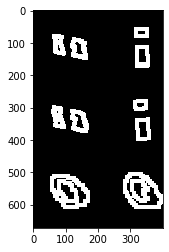

In [28]:
import cv2
from matplotlib import pyplot as plt
img = cv2.imread("/coldjeans/model/rotation/train_0_0.png")
img = cv2.GaussianBlur(img, (11, 11), 5) * 2.0
plt.imshow(img[:, :400])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


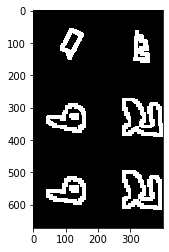

In [29]:
img = cv2.imread("/coldjeans/model/rotation/val_12_1.png")
img = cv2.GaussianBlur(img, (11, 11), 5) * 2.0
plt.imshow(img[:, :400])

## [step3] 3d data to 2d image

#### 3.1 train data convert

def cvt_train_data_2d(data_path, save_path):
    os.makedirs(save_path, exist_ok=True)
    [os.makedirs("%s/%d" % (save_path, i), exist_ok=True) for i in range(10)]
    train_dl = TrainDataLoader(data_path)
    train_loader = DataLoader(dataset=train_dl, batch_size=1, num_workers=4, shuffle=False)

    pbar = tqdm(train_loader, total=len(train_loader))
    for i, (data, label, name) in enumerate(pbar):
        # print(data.shape, label, name)
        img = data2img(data[0], 64)
        cv2.imwrite(os.path.join(save_path, '%d' % label[0], name[0] + '.png'), img)

In [ ]:
# run
cvt_train_data_2d(np_data_path, result_data_path + '/train')

#### 3.2 test data convert (with rotation inference)
inference 한결과를 다시 inference (10번반복)  
rotation model 이 학습한 -pi/2 ~ +pi/2 범위를 벗어난 데이터도 커버 가능 

In [21]:
def inference_cascade_result(weight_path, data_path, save_path):
    pre_weight = torch.load(weight_path)

    os.makedirs(save_path, exist_ok=True)
    [os.remove(p) for p in glob(save_path + '/*.png')]

    model = DeepHoughModel()
    model = model.cuda()
    init_weight = model.state_dict()
    init_weight.update(pre_weight['weight'])
    model.load_state_dict(init_weight)
    model = model.cuda()
    model.eval()

    test_dl = TestRotationLoader(data_path, mode='test', img_size=64)
    test_loader = DataLoader(dataset=test_dl, batch_size=1, num_workers=32, shuffle=False)

    with torch.no_grad():
        pbar = tqdm(test_loader, total=len(test_loader))
        for i, (data, label) in enumerate(pbar):
            dd = data.cpu().detach().numpy()
            for j in range(9):
                pred = model(torch.from_numpy(dd.astype(np.float32)).cuda())
                pp = pred[0].cpu().detach().numpy()
                x, y, z = pp
                dd = test_dl.derotation(-x, -y, -z, dd)
            result_img = data2img(dd[0], 64)
            cv2.imwrite(os.path.join(save_path, '%d.png' % label), result_img)

아래는 10번 cascade 방식으로 하는 과정 시각화  
(행으로 데이터 구분, 열로 cascade 단계 구분)   
3행의 경우 초반에는 제대로 estimation 하지못하지만 결국 수렴하게 됨을 볼 수 있음

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


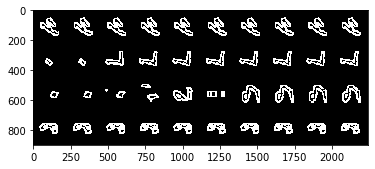

In [58]:
img = cv2.imread("cascade_result.png")
img = cv2.GaussianBlur(img, (5, 5), 5) * 1.2
plt.imshow(img[:900])

나중에 ensemble 을 위해 10개의 rotation model weight 를 이용하여 10개의 test dataset 생성

In [ ]:
# run 10 model for ensemble
for i in range(10):
    ww = glob("%s/%d_*.pth" % (save_model_path, 3*i + 22))[0]
    ss = "%s/test_%d" % (result_data_path, i)
    print(ww, ss)
    inference_cascade_result(ww, np_data_path, ss)

## [step4] train MnistSimpleCNN

mnist dataset sota 인 MnistSimpleCNN 모델에서 M3 모델 사용  
benchmark : https://paperswithcode.com/sota/image-classification-on-mnist  
official code : https://github.com/ansh941/MnistSimpleCNN

#### 4.1 define model

In [30]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as vf

class EMA:
    def __init__(self, model, decay):
        self.decay = decay
        self.shadow = {}
        self.original = {}

        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def __call__(self, model, num_updates):
        decay = min(self.decay, (1.0 + num_updates) / (10.0 + num_updates))
        for name, param in model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                new_average = (1.0 - decay) * param.data + decay * self.shadow[name]
                self.shadow[name] = new_average.clone()

    def assign(self, model):
        for name, param in model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                self.original[name] = param.data.clone()
                param.data = self.shadow[name]

    def resume(self, model):
        for name, param in model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                param.data = self.original[name]

class ModelM3(nn.Module):
    def __init__(self):
        super(ModelM3, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, bias=False)       # output becomes 26x26
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 48, 3, bias=False)      # output becomes 24x24
        self.conv2_bn = nn.BatchNorm2d(48)
        self.conv3 = nn.Conv2d(48, 64, 3, bias=False)      # output becomes 22x22
        self.conv3_bn = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 80, 3, bias=False)      # output becomes 20x20
        self.conv4_bn = nn.BatchNorm2d(80)
        self.conv5 = nn.Conv2d(80, 96, 3, bias=False)      # output becomes 18x18
        self.conv5_bn = nn.BatchNorm2d(96)
        self.conv6 = nn.Conv2d(96, 112, 3, bias=False)     # output becomes 16x16
        self.conv6_bn = nn.BatchNorm2d(112)
        self.conv7 = nn.Conv2d(112, 128, 3, bias=False)    # output becomes 14x14
        self.conv7_bn = nn.BatchNorm2d(128)
        self.conv8 = nn.Conv2d(128, 144, 3, bias=False)    # output becomes 12x12
        self.conv8_bn = nn.BatchNorm2d(144)
        self.conv9 = nn.Conv2d(144, 160, 3, bias=False)    # output becomes 10x10
        self.conv9_bn = nn.BatchNorm2d(160)
        self.conv10 = nn.Conv2d(160, 176, 3, bias=False)   # output becomes 8x8
        self.conv10_bn = nn.BatchNorm2d(176)
        self.fc1 = nn.Linear(11264, 10, bias=False)
        self.fc1_bn = nn.BatchNorm1d(10)

    def get_logits(self, x):
        x = (x - 0.5) * 2.0
        conv1 = F.relu(self.conv1_bn(self.conv1(x)))
        conv2 = F.relu(self.conv2_bn(self.conv2(conv1)))
        conv3 = F.relu(self.conv3_bn(self.conv3(conv2)))
        conv4 = F.relu(self.conv4_bn(self.conv4(conv3)))
        conv5 = F.relu(self.conv5_bn(self.conv5(conv4)))
        conv6 = F.relu(self.conv6_bn(self.conv6(conv5)))
        conv7 = F.relu(self.conv7_bn(self.conv7(conv6)))
        conv8 = F.relu(self.conv8_bn(self.conv8(conv7)))
        conv9 = F.relu(self.conv9_bn(self.conv9(conv8)))
        conv10 = F.relu(self.conv10_bn(self.conv10(conv9)))
        flat1 = torch.flatten(conv10.permute(0, 2, 3, 1), 1)
        logits = self.fc1_bn(self.fc1(flat1))
        return logits

    def forward(self, x):
        logits = self.get_logits(x)
        return F.log_softmax(logits, dim=1)


class RandomRotation(object):
    def __init__(self, degrees, seed=1):
        self.degrees = (-degrees, degrees)
        random.seed(seed)

    @staticmethod
    def get_params(degrees):
        angle = random.uniform(degrees[0], degrees[1])
        return angle

    def __call__(self, img):
        angle = self.get_params(self.degrees)
        return vf.rotate(img, angle, False, False, None, None)


#### 4.2 define dataloader

In [36]:
# 4.2 define dataloader

class MnistRotaDatasetLabel(torch.utils.data.Dataset):
    def __init__(self, img_path, mode=None, transform=None):
        self.mode = mode
        name_list, img_list, label_list = [], [], []
        if mode == 'test':
            for n in range(50000, 90000):
                name_list.append(n)
                img_list.append(os.path.join(img_path, '%s.png' % n))
                label_list.append(0)
        else:
            name_list, img_list, label_list = self.get_img_list(img_path)
        self.name_data = name_list
        self.x_data = img_list
        self.y_data = label_list
        self.transform = transform

    def get_img_list(self, data_path):
        img_list = []
        label_list = []
        name_list = []
        for i in range(10):
            sub_path = os.path.join(data_path, 'train/%d' % i)
            sub_img_list = [os.path.join(sub_path, s) for s in os.listdir(sub_path) if 'png' in s]
            sub_img_num = len(sub_img_list)
            sub_img_list.sort()
            if self.mode == 'train':
                sub_img_list = sub_img_list[:int(sub_img_num*0.9)]
            elif self.mode == 'val':
                sub_img_list = sub_img_list[int(sub_img_num*0.9):]
            else:
                raise AssertionError
            sub_name = [p.split(os.sep)[-1] for p in sub_img_list]
            name_list += sub_name
            sub_label = [i for _ in range(len(sub_img_list))]
            img_list += sub_img_list
            label_list += sub_label

        return name_list, img_list, label_list

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = cv2.imread(self.x_data[idx], 0)
        x[x > 1] = 255
        x = cv2.resize(x, (28, 28))
        x = np.reshape(x, (28, 28, 1)).astype(np.float32)
        y = self.y_data[idx]
        n = self.name_data[idx]
        x = transforms.ToPILImage()(x)
        if self.transform:
            x = self.transform(x)
        x = transforms.ToTensor()(np.array(x)/255)
        return x, y, n


#### 4.3 train cnn model
train loss 가 가장 작은 모델을 저장

In [49]:

import warnings
warnings.filterwarnings("ignore")
def train(data_path, save_path, p_seed=0, p_epochs=150):
    # random number generator seed ------------------------------------------------#
    SEED = p_seed
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    np.random.seed(SEED)

    # number of epochs ------------------------------------------------------------#
    NUM_EPOCHS = p_epochs

    # file names ------------------------------------------------------------------#
    os.makedirs("%s" % save_path, exist_ok=True)
    MODEL_FILE = str("%s/model%03d.pth" % (save_path, SEED))

    # enable GPU usage ------------------------------------------------------------#
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    if use_cuda == False:
        print("WARNING: CPU will be used for training.")
        exit(0)

    # data augmentation methods ---------------------------------------------------#
    transform = transforms.Compose([
        RandomRotation(20, seed=SEED),
        transforms.RandomAffine(0, translate=(0.2, 0.2)),
        ])

    # data loader -----------------------------------------------------------------#
    train_dataset = MnistRotaDatasetLabel(data_path, mode='train', transform=transform)
    val_dataset = MnistRotaDatasetLabel(data_path, mode='val', transform=None)
    train_loader = torch.utils.data.DataLoader(train_dataset, num_workers=4, batch_size=120, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, num_workers=4, batch_size=120, shuffle=True)

    # model selection -------------------------------------------------------------#
    model = ModelM3().to(device)

    # hyperparameter selection ----------------------------------------------------#
    ema = EMA(model, decay=0.999)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)

    # global variables ------------------------------------------------------------#
    g_step = 0
    max_correct = 0
    min_loss = 10

    # training and evaluation loop ------------------------------------------------#
    
    for epoch in range(NUM_EPOCHS):
        #--------------------------------------------------------------------------#
        # train process                                                            #
        #--------------------------------------------------------------------------#
        model.train()
        train_loss = 0
        train_corr = 0
        for batch_idx, (data, target, name) in enumerate(train_loader):
            data, target = data.to(device), target.to(device, dtype=torch.int64)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            train_pred = output.argmax(dim=1, keepdim=True)
            train_corr += train_pred.eq(target.view_as(train_pred)).sum().item()
            train_loss += F.nll_loss(output, target, reduction='sum').item()
            loss.backward()
            optimizer.step()
            g_step += 1
            ema(model, g_step)
#             if batch_idx % 100 == 0:
#                 print('Train Epoch: {} [{:05d}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                     epoch, batch_idx * len(data), len(train_loader.dataset),
#                     100. * batch_idx / len(train_loader), loss.item()))
        train_loss /= len(train_loader.dataset)

        if (train_loss < min_loss):
            torch.save(model.state_dict(), MODEL_FILE)
            min_loss = train_loss
#             print("Save Model Best train loss %.4f" % train_loss)
        #--------------------------------------------------------------------------#
        # test process                                                             #
        #--------------------------------------------------------------------------#
        model.eval()
        ema.assign(model)
        val_loss = 0
        val_correct = 0
        val_pred = np.zeros(0)
        val_target = np.zeros(0)
        with torch.no_grad():
            for data, target, name in val_loader:
                data, target = data.to(device), target.to(device,  dtype=torch.int64)
                output = model(data)
                val_loss += F.nll_loss(output, target, reduction='sum').item()
                pred = output.argmax(dim=1, keepdim=True)
                val_pred = np.append(val_pred, pred.cpu().numpy())
                val_target = np.append(val_target, target.cpu().numpy())
                val_correct += pred.eq(target.view_as(pred)).sum().item()
        val_loss /= len(val_loader.dataset)
        val_accuracy = 100 * val_correct / len(val_loader.dataset)
#         print('Val set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#             val_loss, val_correct, len(val_loader.dataset), val_accuracy))
        ema.resume(model)

        lr_scheduler.step()


In [60]:
img_data_path = "/coldjeans/Data/img"
save_model_path = "/coldjeans/model/cnn"
save_result_path = "/coldjeans/result"

#### ensemble 을 위해 seed 값 다르게하여 10번 학습 진행

In [50]:
# run train
for i in range(10):
    print('train', i)
    train(img_data_path,
          save_model_path,
          p_seed=i,
          p_epochs=100)

train 0
train 1
train 2
train 3
train 4
train 5
train 6
train 7
train 8
train 9


#### 4.4 inference cnn model

In [68]:
def inference(data_path, model_path, save_path, idx, p_seed=0):
    os.makedirs(save_path, exist_ok=True)
    for i in range(10):
        os.makedirs(os.path.join(save_path, str(i)), exist_ok=True)
    # enable GPU usage ------------------------------------------------------------#
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    if use_cuda == False:
        print("WARNING: CPU will be used for training.")
        exit(0)

    # data loader -----------------------------------------------------------------#
    test_dataset = MnistRotaDatasetLabel(data_path, mode='test', transform=None)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, num_workers=16, shuffle=False)

    # model selection -------------------------------------------------------------#
    model1 = ModelM3().to(device)

    print('load weight', "%s/model%03d.pth" % (model_path, p_seed))
    model1.load_state_dict(torch.load("%s/model%03d.pth" % (model_path, p_seed)))

    model1.eval()

    with open(os.path.join(save_path, 'result_%d_%02d.txt' % (idx, p_seed)), 'w') as f:
        f.write("")

    with torch.no_grad():
        correct_num = 0
#         tq = tqdm(test_loader, total=len(test_loader))
        for data, label, name in test_loader:
            # data = data.to(device)
            output = model1(data.to(device))
            pred = output.argmax(dim=1, keepdim=True)
            label = label.to(device)
            cc = pred.eq(label.view_as(pred)).sum().item()
            correct_num += cc
            b_size = data.shape[0]
            for b in range(b_size):
                with open(os.path.join(save_path, 'result_%d_%02d.txt' % (idx, p_seed)), 'a') as f:
                    f.write("%d, %d\n" % (int(name[b]), pred[b]))
#         print('total', correct_num, correct_num/40000)

#### 위에서 만든 10개의 test dataset, 10개의 model 을 조합하여 100번 inference 진행

In [69]:
for j in range(10):
    test_data = os.path.join(img_data_path, 'test_%d' % j)
    for i in range(10):
        print('inference', i, test_data)
        inference(test_data,
                  save_model_path,
                  save_result_path,
                  idx=j,
                  p_seed=i)

inference 0 /coldjeans/Data/img/test_0
load weight /coldjeans/model/cnn/model000.pth
inference 1 /coldjeans/Data/img/test_0
load weight /coldjeans/model/cnn/model001.pth
inference 2 /coldjeans/Data/img/test_0
load weight /coldjeans/model/cnn/model002.pth
inference 3 /coldjeans/Data/img/test_0
load weight /coldjeans/model/cnn/model003.pth
inference 4 /coldjeans/Data/img/test_0
load weight /coldjeans/model/cnn/model004.pth
inference 5 /coldjeans/Data/img/test_0
load weight /coldjeans/model/cnn/model005.pth
inference 6 /coldjeans/Data/img/test_0
load weight /coldjeans/model/cnn/model006.pth
inference 7 /coldjeans/Data/img/test_0
load weight /coldjeans/model/cnn/model007.pth
inference 8 /coldjeans/Data/img/test_0
load weight /coldjeans/model/cnn/model008.pth
inference 9 /coldjeans/Data/img/test_0
load weight /coldjeans/model/cnn/model009.pth
inference 0 /coldjeans/Data/img/test_1
load weight /coldjeans/model/cnn/model000.pth
inference 1 /coldjeans/Data/img/test_1
load weight /coldjeans/mod

## [step5] ensemble result
100개의 inference 결과를 조합하여 result.csv 생성

In [72]:
# step5 ensemble result

import os
import numpy as np
from glob import glob
from collections import defaultdict


def topk(arr):
    count = defaultdict(int)
    for a in arr:
        count[a] += 1
    # print(count, max(count, key=count.get))
    return max(count, key=count.get)


def ensemble_result(txt_path, save_path):
    txt_list = glob(os.path.join(txt_path, '*.txt'))
    txt_list.sort()
    result = defaultdict(list)
    for txt_l in txt_list:
        with open(txt_l, 'r') as f:
            data = f.read().split('\n')[:-1]
            print(txt_l, len(data))
            if len(data) < 40000:
                continue
            for d in data:
                idx, cat = d.split(', ')
                result[idx].append(int(cat))
    num_not_all = 0
    # for i in range(40000, 90000, 1):

    with open(os.path.join(save_path, 'result.csv'), 'w') as f:
        f.write("ID,label")
    for k, v in result.items():
        with open(os.path.join(save_path, 'result.csv'), 'a') as f:
            f.write('\n')
        # print(k, np.median(np.array(v, dtype=int)))
        cc = topk(v)
        if np.sum(np.array(v) != v[0]):
            num_not_all += 1
#             print(k, v, cc)
        with open(os.path.join(save_path, 'result.csv'), 'a') as f:
            f.write('%s,%d' % (k, cc))
    
    print(num_not_all)

In [73]:
# run ensemble
ensemble_result('/coldjeans/result', '/coldjeans/result')

/coldjeans/result/result_0_00.txt 40000
/coldjeans/result/result_0_01.txt 40000
/coldjeans/result/result_0_02.txt 40000
/coldjeans/result/result_0_03.txt 40000
/coldjeans/result/result_0_04.txt 40000
/coldjeans/result/result_0_05.txt 40000
/coldjeans/result/result_0_06.txt 40000
/coldjeans/result/result_0_07.txt 40000
/coldjeans/result/result_0_08.txt 40000
/coldjeans/result/result_0_09.txt 40000
/coldjeans/result/result_1_00.txt 40000
/coldjeans/result/result_1_01.txt 40000
/coldjeans/result/result_1_02.txt 40000
/coldjeans/result/result_1_03.txt 40000
/coldjeans/result/result_1_04.txt 40000
/coldjeans/result/result_1_05.txt 40000
/coldjeans/result/result_1_06.txt 40000
/coldjeans/result/result_1_07.txt 40000
/coldjeans/result/result_1_08.txt 40000
/coldjeans/result/result_1_09.txt 40000
/coldjeans/result/result_2_00.txt 40000
/coldjeans/result/result_2_01.txt 40000
/coldjeans/result/result_2_02.txt 40000
/coldjeans/result/result_2_03.txt 40000
/coldjeans/result/result_2_04.txt 40000


## Appendix
hough line transform 알고리즘을 3d 에서 확장한다면?

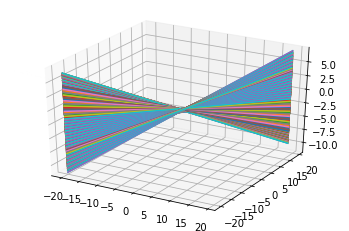

In [74]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import h5py


class Lind3D:
    def __init__(self, a, b, c):
        self.a = a
        self.b = b
        self.c = c
    def __call__(self, xx, yy, *args, **kwargs):
        z = 1/self.c - (self.a*xx/self.c + self.b*yy/self.c)
        return z


test_all = h5py.File("/coldjeans/Data/raw/test.h5", 'r')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
idx = '80000'
dot = test_all[idx][:1000, :]
for dd in dot:
    a, b, c = dd
    ftn = Lind3D(a, b, c)
    x = np.array(list(range(-20, 20, 1)))
    y = np.array(list(range(-20, 20, 1)))
    z = []
    for i, j in zip(x, y):
        z_ = ftn(i, j)
        # print(z_)
        z.append(z_)
    z = np.array(z)
    ax.plot(x, y, z)
plt.show()